<a href="https://colab.research.google.com/github/azrazainol/STQD6324_Assignment_02/blob/main/STQD6324_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2006 Flight Data**

This analysis provides insights on airline performance based on flight data from 2006. The insights are extracted using Hive (SQL) and is analysed below through visualisation.

When purchasing airline tickets, people would most likely go for times or airlines with low cancellation and delay rates. Due to the that, at the end of the analysis, a logistic regression model is trained using the data to find whether certain conditions may be suitable or not to purchase flight tickets so that flight delays or cancellations may be avoided.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
flights = pd.read_csv('/content/drive/MyDrive/hdfs/2006.csv')
flights

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,27,12,0,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141917,2006,12,29,5,1246.0,1249,1452.0,1459,DL,1675,...,6,12,0,NaN,0,0,0,0,0,0
7141918,2006,12,29,5,1225.0,1155,2033.0,1931,DL,1676,...,12,35,0,NaN,0,30,0,32,0,0
7141919,2006,12,29,5,2118.0,2115,2254.0,2241,DL,1676,...,9,27,0,NaN,0,0,0,0,0,0
7141920,2006,12,29,5,2122.0,2127,2209.0,2223,DL,1677,...,5,21,0,NaN,0,0,0,0,0,0


# **Import HDFS Files**

In [4]:
# pd.read_csv('')

# 1
ot_hour = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_timeOfDay.csv')
ot_day = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_dayOfWeek.csv')
ot_day = ot_day.sort_values(by='dayofweek', ascending=True)
ot_month = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_month.csv')
ot_season = pd.read_csv('/content/drive/MyDrive/hdfs/1_ot_season.csv')

# 2
delay_factor = pd.read_csv('/content/drive/MyDrive/hdfs/2_delay_factor.csv')

# 3
cancellation_factor = pd.read_csv('/content/drive/MyDrive/hdfs/3_cancellation_code.csv')

# 4
frequent_cancellation = pd.read_csv('/content/drive/MyDrive/hdfs/4_flightnum_cancellation.csv')
frequent_delay = pd.read_csv('/content/drive/MyDrive/hdfs/4_flightnum_delay_count.csv')

In [6]:
rename_dict = {'avg_weatherdelay': 'Weather Delay',
               'avg_nasdelay': 'NAS Delay',
               'avg_securitydelay': 'Security Delay',
               'avg_lateaircraftdelay': 'Late Aircraft Delay',
               'avg_carrierdelay': 'Carrier Delay'}

delay_factor = delay_factor.rename(columns=rename_dict)

delay_factor = delay_factor.T.reset_index()
delay_factor.columns = ['Delay Type', 'Average Delay (minutes)']
delay_factor = delay_factor.sort_values(by='Average Delay (minutes)', ascending=False)

In [7]:
cancellation_mapping = {'A': 'carrier', 'B': 'weather', 'C': 'NAS', 'D': 'security'}
cancellation_factor['cancellation_reason'] = cancellation_factor['cancellationcode'].map(cancellation_mapping)

In [159]:
top_40_cancellations = frequent_cancellation.head(40)
top_40_cancellations['flightnum'] = top_40_cancellations['flightnum'].astype(str);
top_20_delays = frequent_delay.head(20)
top_20_avg_delays = frequent_delay.sort_values(by='avg_arrdelay', ascending=False).head(20)

<ipython-input-159-fe1d2669fb7d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_40_cancellations['flightnum'] = top_40_cancellations['flightnum'].astype(str);


In [5]:
# extra insights
avg_cancel_month = pd.read_csv('/content/drive/MyDrive/hdfs/E_ts_analysis.csv')
avg_delay_carrier = pd.read_csv('/content/drive/MyDrive/hdfs/E_delay_by_carrier.csv')
avg_cancel_carrier = pd.read_csv('/content/drive/MyDrive/hdfs/E_cancel_by_carrier.csv')

In [65]:
avg_delay_carrier = avg_delay_carrier.sort_values(by='avg_arrdelay', ascending=False)
top10_avg_delay_carrier = avg_delay_carrier.head(10)

avg_cancel_carrier = avg_cancel_carrier.sort_values(by='cancellation_rate', ascending=False)
top10_avg_cancel_carrier = avg_cancel_carrier.head(10)

# **Visualisation**

### **Average Arrival Delay**

Average arrival delay by:
- departure time
- day of the week
- month
- season

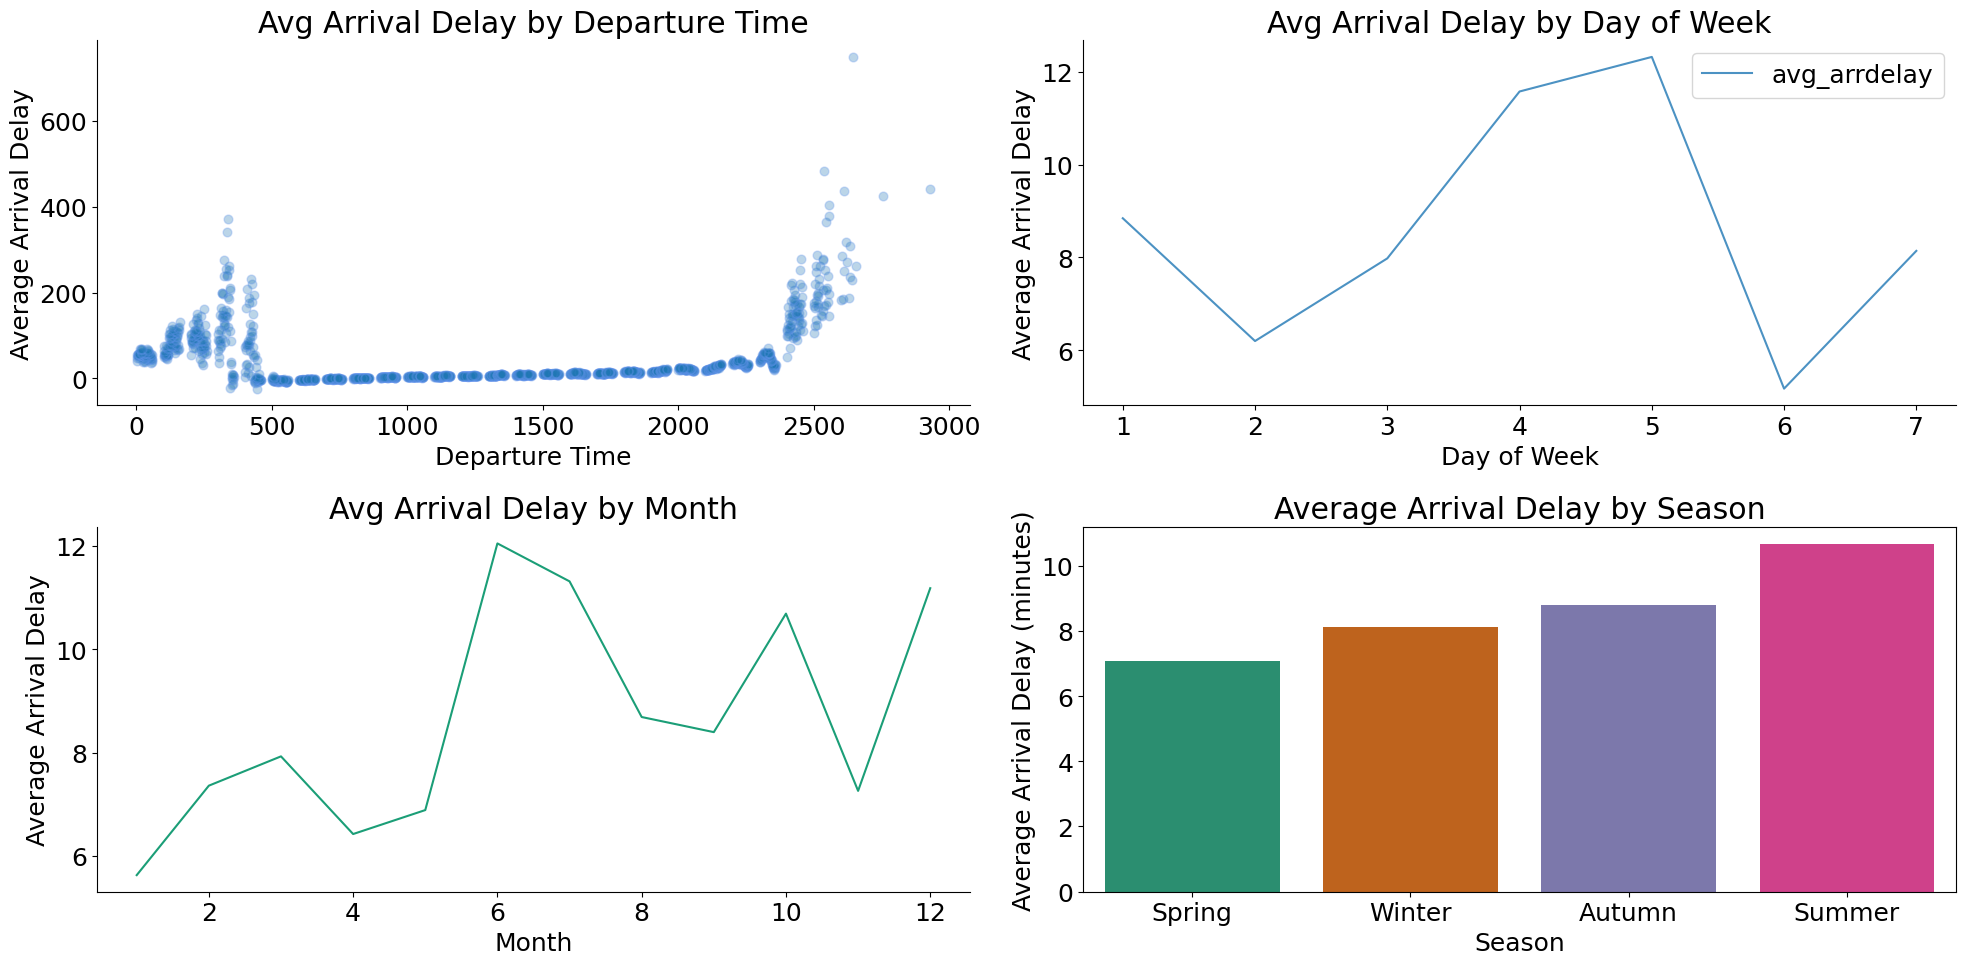

In [131]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Plot 1: Average Arrival Delay by Departure Time
plt.subplot(2, 2, 1)
ot_hour.plot(kind='scatter', x='deptime', y='avg_arrdelay', s=40, alpha=.3, marker='o', facecolor='blue',  edgecolor='cornflowerblue', ax=plt.gca())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Average Arrival Delay')

# Plot 2: Average Arrival Delay by Day of Week
plt.subplot(2, 2, 2)
ot_day.plot(kind='line', x='dayofweek', y='avg_arrdelay', alpha=.8, ax=plt.gca())
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Arrival Delay')

# Plot 3: Average Arrival Delay by Month
plt.subplot(2, 2, 3)
df_sorted = ot_month.sort_values('month', ascending=True)
palette = list(sns.color_palette('Dark2'))
plt.plot(df_sorted['month'], df_sorted['avg_arrdelay'], label='Avg Arrival Delay', color=palette[0])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Avg Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay')

# Plot 4: Average Arrival Delay by Season
plt.subplot(2, 2, 4)
sns.barplot(data=ot_season, y='avg_arrdelay', x='season', hue='season',palette='Dark2')
plt.title('Average Arrival Delay by Season')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xlabel('Season')

plt.tight_layout()
plt.show();

### **Delay and Cancellation Reasons**

The delay and cancellation rate/number by reason:
- late aircraft (delay only)
- National Air System (NAS)
- carrier
- weather
- security

<ipython-input-143-9284560db729>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=delay_factor, y='Average Delay (minutes)', x='Delay Type', palette='viridis')
<ipython-input-143-9284560db729>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=cancellation_factor, x='cancellation_reason', y='cancellation_count', palette='viridis')


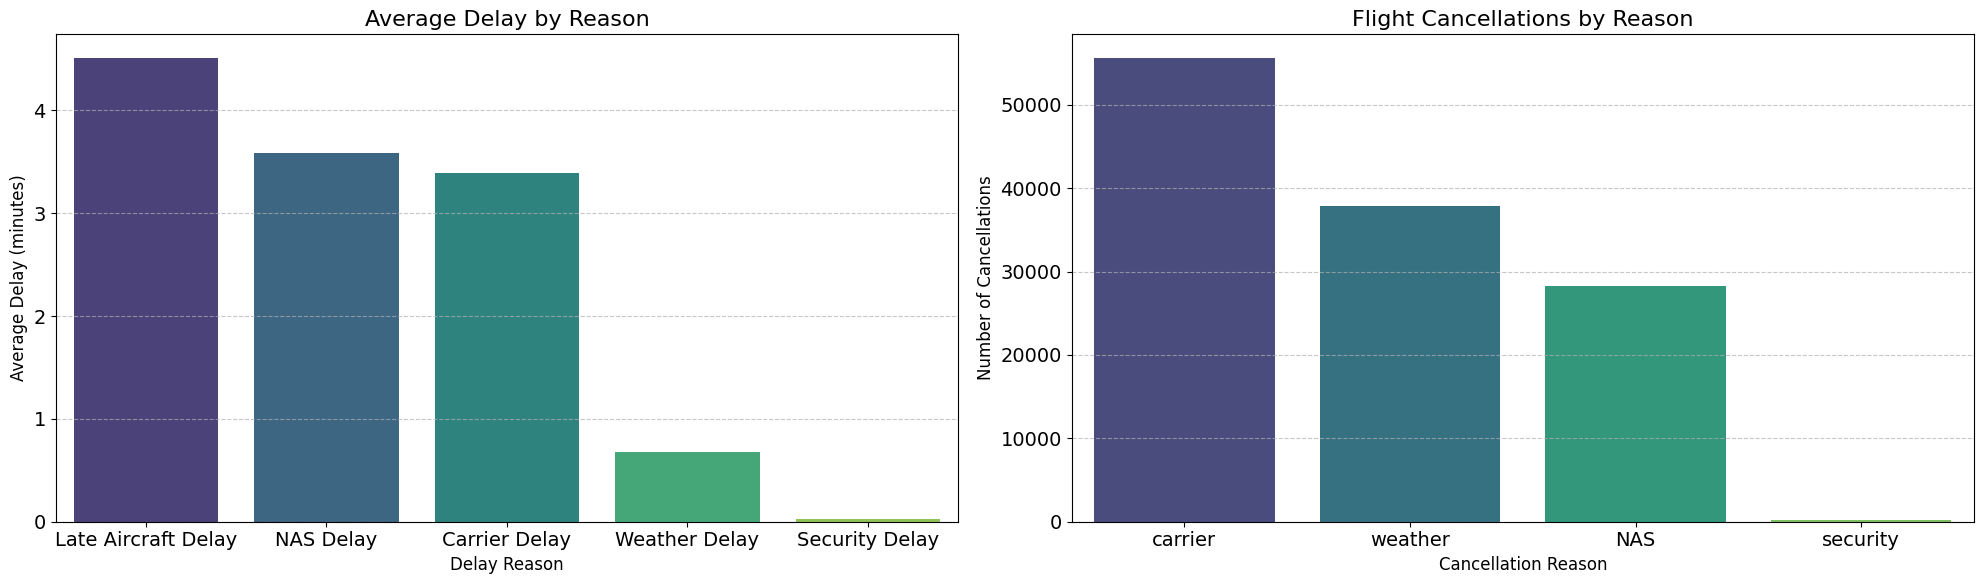

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 12})

# Plot Average Delay by Type
sns.barplot(ax=axes[0], data=delay_factor, y='Average Delay (minutes)', x='Delay Type', palette='viridis')
axes[0].set_title('Average Delay by Reason', fontsize=16)
axes[0].set_ylabel('Average Delay (minutes)', fontsize=12)
axes[0].set_xlabel('Delay Reason', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Flight Cancellations by Reason
sns.barplot(ax=axes[1], data=cancellation_factor, x='cancellation_reason', y='cancellation_count', palette='viridis')
axes[1].set_title('Flight Cancellations by Reason', fontsize=16)
axes[1].set_xlabel('Cancellation Reason', fontsize=12)
axes[1].set_ylabel('Number of Cancellations', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

### **Delay Insights Based on Flight Number**

- Top 20 Flights with Highest Average Delay
- Average Delay for Top 20 Flights with Highest Delay Count
- Delay Count for Top 20 Flights with Highest Average Delay
- Top 20 Flights with Highest Delay Count

<ipython-input-88-306793a20ca5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_avg_delays, y='avg_arrdelay', x='flightnum', palette='magma')
<ipython-input-88-306793a20ca5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
<ipython-input-88-306793a20ca5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_avg_delays, y='delay_count', x='flightnum', palette='magma')
<ipython-input-88-306793a20ca5>:23: FutureWarning: 

Passing `palette` without assi

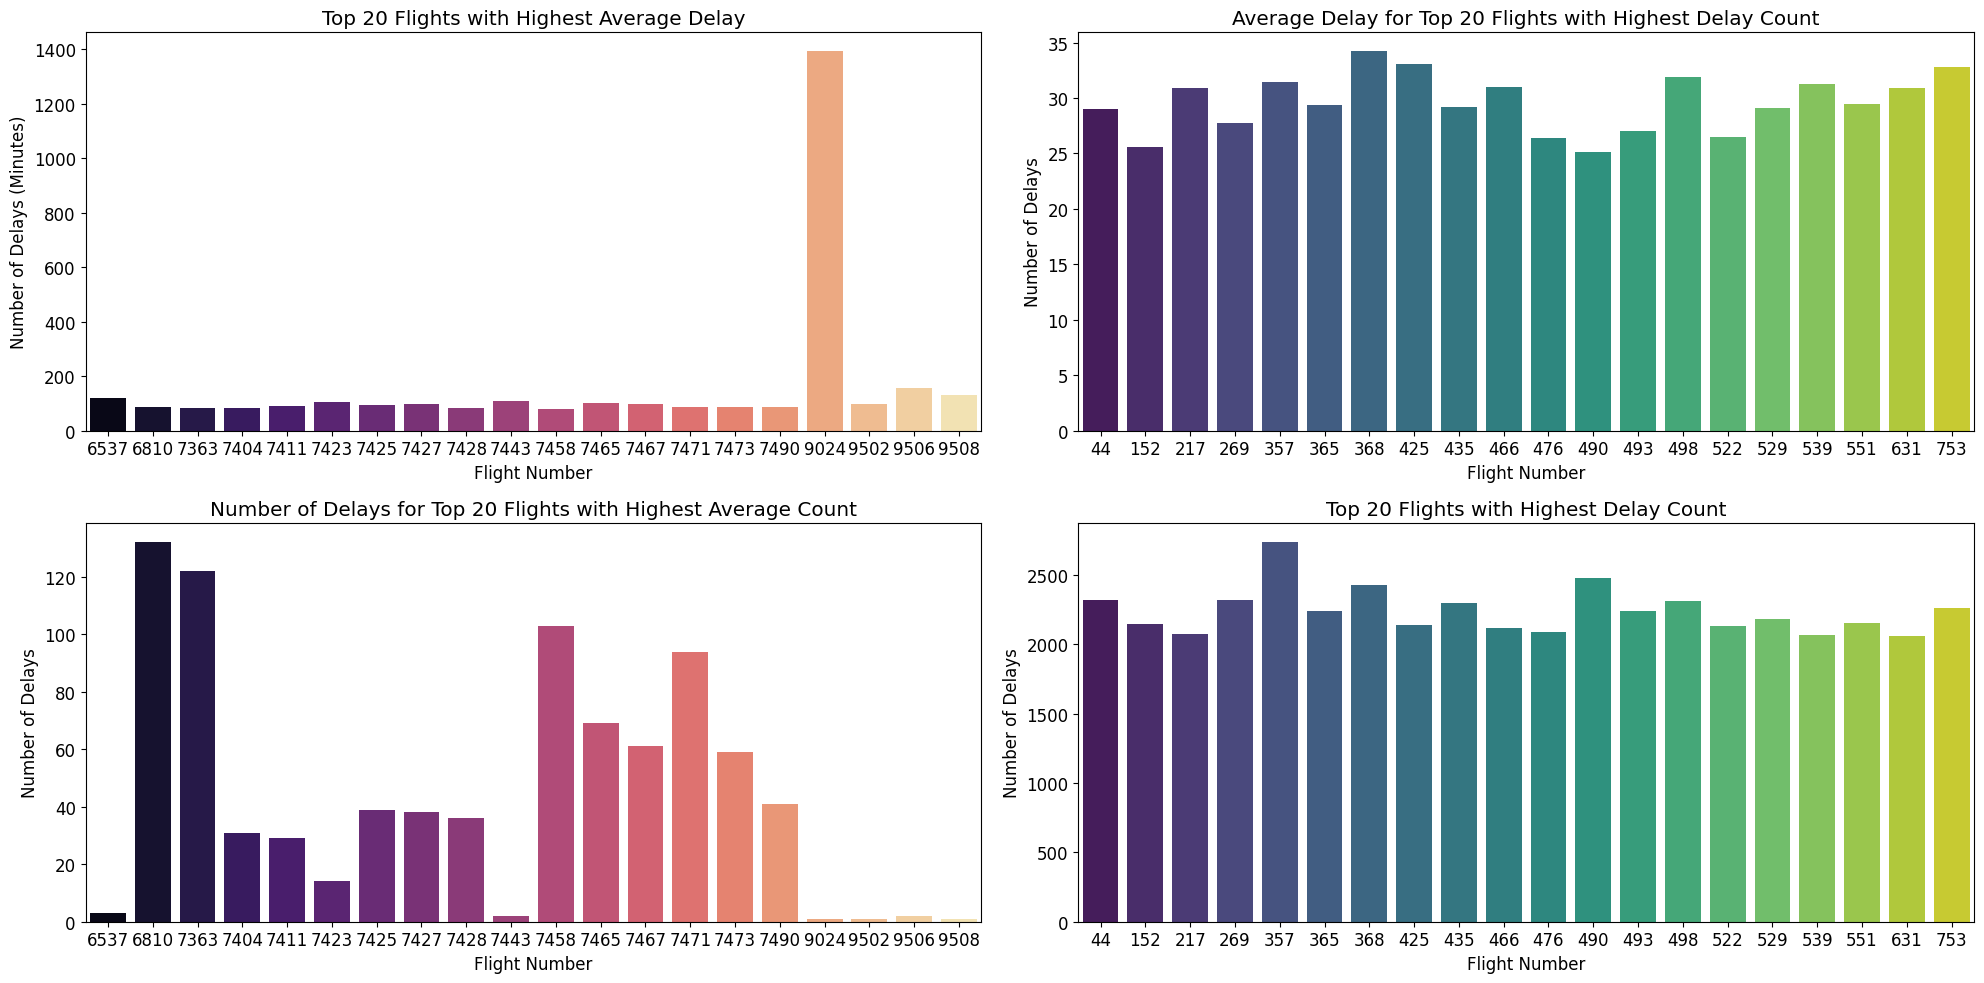

In [88]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
sns.barplot(data=top_20_avg_delays, y='avg_arrdelay', x='flightnum', palette='magma')
plt.title('Top 20 Flights with Highest Average Delay')
plt.ylabel('Number of Delays (Minutes)')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 2)
sns.barplot(data=top_20_delays, y='avg_arrdelay', x='flightnum', palette='viridis')
plt.title('Average Delay for Top 20 Flights with Highest Delay Count')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 3)
sns.barplot(data=top_20_avg_delays, y='delay_count', x='flightnum', palette='magma')
plt.title('Number of Delays for Top 20 Flights with Highest Average Delay')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.subplot(2, 2, 4)
sns.barplot(data=top_20_delays, y='delay_count', x='flightnum', palette='viridis')
plt.title('Top 20 Flights with Highest Delay Count')
plt.ylabel('Number of Delays')
plt.xlabel('Flight Number')

plt.tight_layout()
plt.show();

<ipython-input-160-67bd2ad36113>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_40_cancellations, y='cancellation_count', x='flightnum', palette='Reds_d')


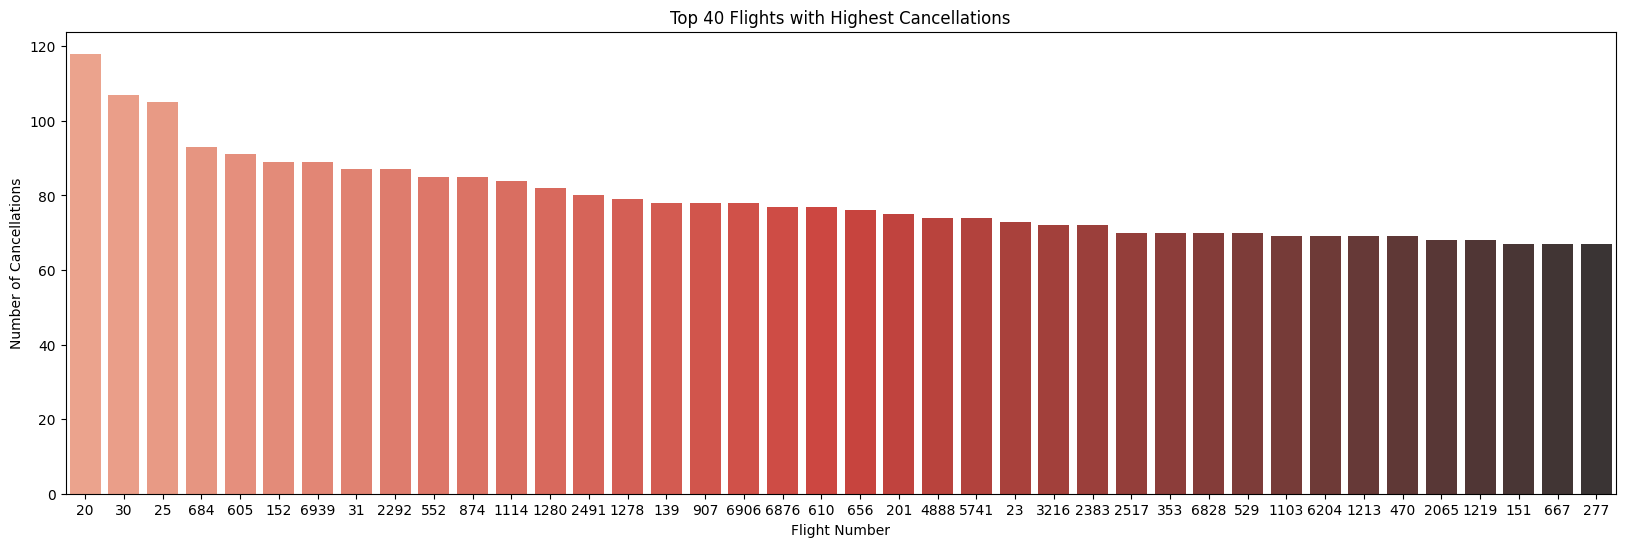

In [160]:
plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size': 10, 'lines.markersize': 10})

sns.barplot(data=top_40_cancellations, y='cancellation_count', x='flightnum', palette='Reds_d')
plt.title('Top 40 Flights with Highest Cancellations')
plt.ylabel('Number of Cancellations')
plt.xlabel('Flight Number')

plt.show();

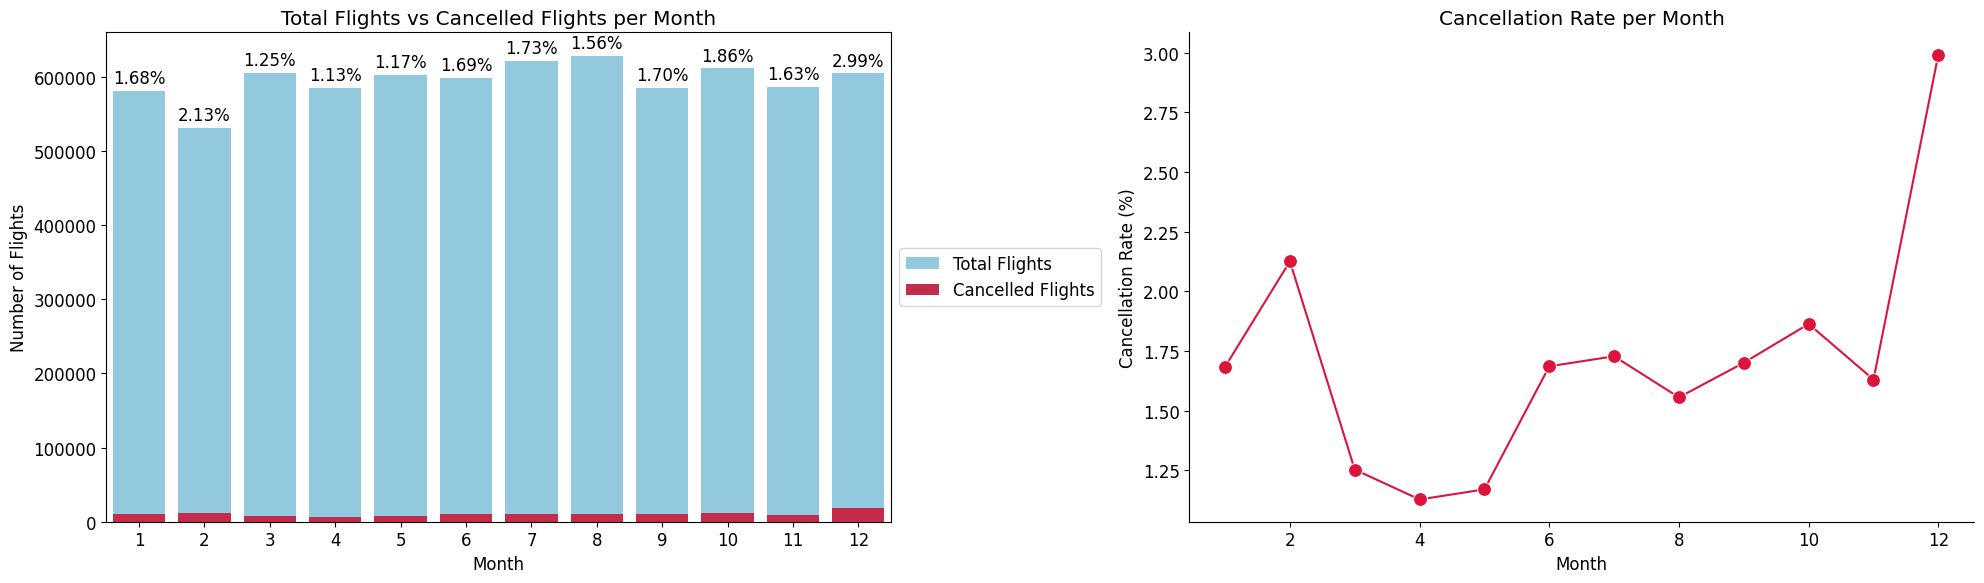

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 12, 'lines.markersize': 10})

# plot 1
sns.barplot(x='month', y='total_flights', data=avg_cancel_month, color='skyblue', label='Total Flights', ax=axs[0])
sns.barplot(x='month', y='cancelled_flights', data=avg_cancel_month, color='crimson', label='Cancelled Flights', ax=axs[0])

for i in range(len(avg_cancel_month)):
    axs[0].text(i, avg_cancel_month['total_flights'][i] + 5000, f"{avg_cancel_month['cancellation_rate'][i]:.2f}%", ha='center', va='bottom')

axs[0].set_title('Total Flights vs Cancelled Flights per Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Flights')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot 2
sns.lineplot(x='month', y='cancellation_rate', data=avg_cancel_month, marker='o', ax=axs[1], color='crimson')

axs[1].set_title('Cancellation Rate per Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Cancellation Rate (%)')
axs[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

<ipython-input-113-c2be7f229cff>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='avg_arrdelay', x='uniquecarrier', data=top10_avg_delay_carrier, palette='Blues_d', ax=axs[0])
<ipython-input-113-c2be7f229cff>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='cancellation_rate', x='uniquecarrier', data=top10_avg_cancel_carrier, palette='Reds_d', ax=axs[1])


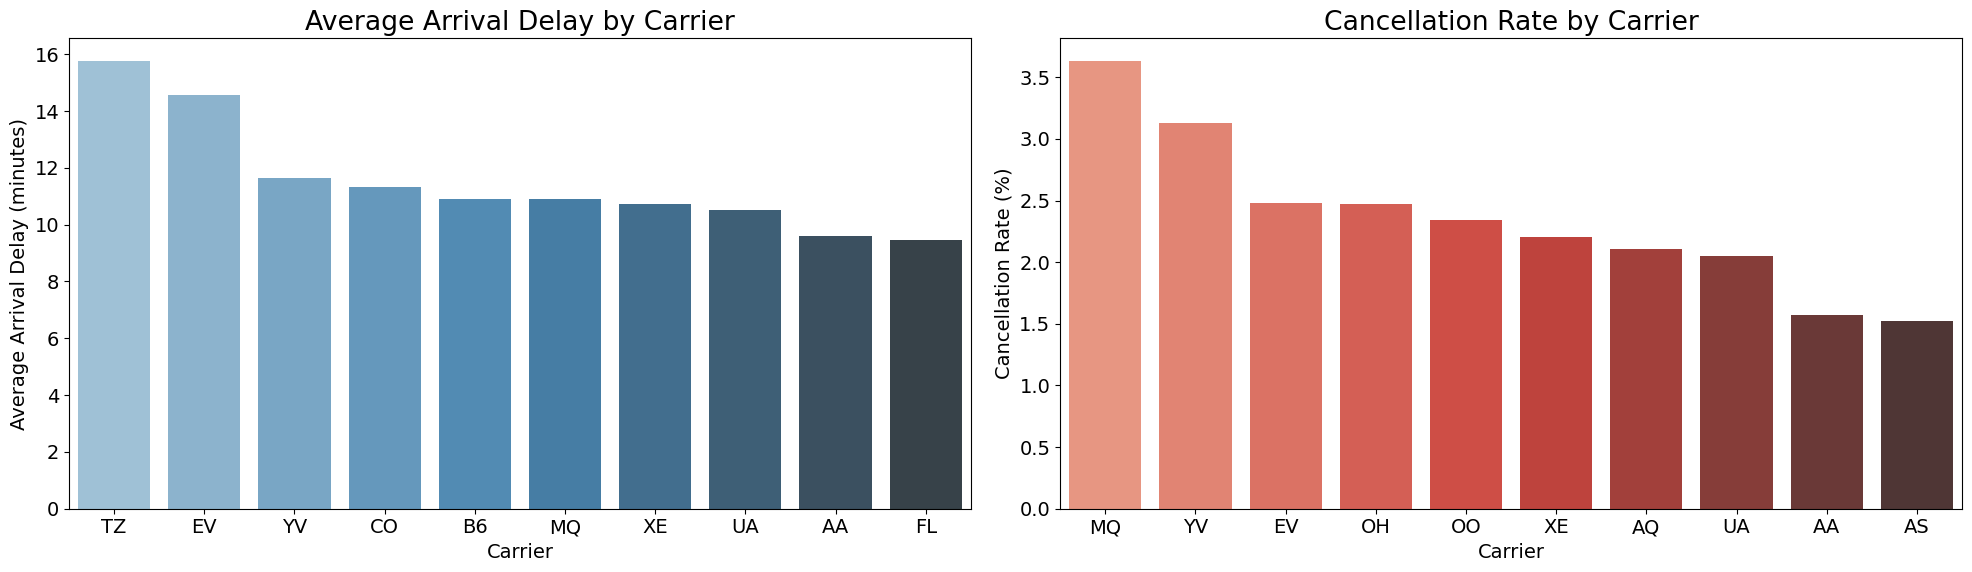

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 16, 'lines.markersize': 10})

# avg_arrdelay by carrier
sns.barplot(y='avg_arrdelay', x='uniquecarrier', data=top10_avg_delay_carrier, palette='Blues_d', ax=axs[0])
axs[0].set_title('Average Arrival Delay by Carrier')
axs[0].set_ylabel('Average Arrival Delay (minutes)')
axs[0].set_xlabel('Carrier')

# cancellation_rate by carrier
sns.barplot(y='cancellation_rate', x='uniquecarrier', data=top10_avg_cancel_carrier, palette='Reds_d', ax=axs[1])
axs[1].set_title('Cancellation Rate by Carrier')
axs[1].set_ylabel('Cancellation Rate (%)')
axs[1].set_xlabel('Carrier')

plt.tight_layout()
plt.show()

In [92]:
conditions = ((flights['Cancelled'] == 1) |
              (flights['CarrierDelay'] > 0) |
              (flights['WeatherDelay'] > 0) |
              (flights['NASDelay'] > 0) |
              (flights['SecurityDelay'] > 0) |
              (flights['LateAircraftDelay'] > 0))

flights['DelayedOrCancelled'] = conditions.astype(int)

In [ ]:
flights.info()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [52]:
features = flights[['CRSDepTime', 'CRSArrTime', 'DayofMonth', 'Month', 'Distance']] #, 'DayOfWeek']] #, 'TaxiIn', 'TaxiOut']]
target = flights['DelayedOrCancelled']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123)

In [53]:
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [54]:
logistic_model = LogisticRegression(class_weight='balanced', max_iter=500)
logistic_model.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=500)

In [55]:
y_pred = logistic_model.predict(X_test)

In [134]:
y_pred

array([1, 1, 0, ..., 0, 0, 1])

In [56]:
# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}');

Accuracy: 0.58


In [57]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix);

Confusion Matrix:
[[917728 702124]
 [206874 315851]]


In [58]:
# Print the classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report);

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67   1619852
           1       0.31      0.60      0.41    522725

    accuracy                           0.58   2142577
   macro avg       0.56      0.59      0.54   2142577
weighted avg       0.69      0.58      0.61   2142577



In [132]:
features

,CRSDepTime,CRSArrTime,DayofMonth,Month,Distance
0,745,1018,11,1,1587
1,1053,1318,11,1,1587
2,1915,2133,11,1,1587
3,1755,1933,11,1,872
4,832,1015,11,1,872
...,...,...,...,...,...
7141917,1249,1459,29,12,745
7141918,1155,1931,29,12,2182
7141919,2115,2241,29,12,403
7141920,2127,2223,29,12,585


In [133]:
predict_1 = {
    'CRSDepTime': [1159, 2310, 930, 1140],
    'CRSArrTime': [1600, 130, 1425, 2050],
    'DayofMonth': [30, 14, 5, 23],
    'Month': [8, 12, 2, 6],
    'Distance': [1587, 745, 2182, 2558]
}

predict_df = pd.DataFrame(predict_1)

In [136]:
prediction_results = logistic_model.predict(predict_df)
prediction_results

array([0, 1, 0, 1])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 10, 'lines.markersize': 10})

# avg_arrdelay by carrier
sns.barplot(data=top_20_cancellations, y='cancellation_count', x='flightnum', palette='Reds_d', ax=axs[0])
axs[0].set_title('Top 20 Flights with Highest Cancellations')
axs[0].set_ylabel('Number of Cancellations')
axs[0].set_xlabel('Flight Number')

# cancellation_rate by carrier
sns.barplot(data=bottom_20_cancellations, y='cancellation_count', x='flightnum', palette='Greens_d', ax=axs[1])
axs[1].set_title('Top 20 Flights with Lowest Cancellations')
axs[1].set_ylabel('Number of Cancellations')
axs[1].set_xlabel('Flight Number')

plt.tight_layout()
plt.show()